In [1]:
from plotnine import *
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import pie, axis, show
import seaborn as sns
from pandas.api.types import CategoricalDtype
import t_test
plt.rcParams['figure.figsize'] = [20, 8]

## Kickstarter Data explore
- Project duration은 최소 1일부터 ~ 60일 
- Pledge는 project가 live할 때, 언제든지 취소가 가능함 (따라서, 최종적으로 실패했더라도 중간에 project goal을 넘을 수 있음)
- Outlier값이 상당히 많은편, Outlier를 제거하고 box plot을 그리면 뚜렷한 차이가 보임

In [2]:
df = pd.read_csv('analysis_data.csv',encoding='utf-16')

In [3]:
df.head()

,Project_Id,Project_launched_at,Project_deadline,Project_goal,Project_category,Date,Days_to_go,Pledged,Options_number,Title_count,...,diff,Success,backer1,backer2,backer3,ratio1,ratio2,ratio3,Top_category,super_category
0,1000414645,1560292936,1562884936,10000.0,Science Fiction,1.562814e+09,19,20139.0,12.0,35.0,...,2.0,1,13,17,25,37.730000,39.180000,44.940000,Film & Video,Film
1,1002877193,1559689942,1562281942,3000.0,Video Games,1.562213e+09,19,3217.0,9.0,13.0,...,2.0,1,127,149,153,48.733333,56.233333,58.400000,Games,Games
2,1002950518,1559343638,1561935638,500.0,Comics,1.561874e+09,17,1306.0,11.0,47.0,...,2.0,1,15,19,22,77.600000,89.800000,105.800000,Comics,Comics & Illustartion
3,1006560474,1559058077,1561650077,100.0,Product Design,1.561596e+09,15,461.0,3.0,48.0,...,1.0,1,12,17,18,124.000000,173.000000,185.000000,Design,Design & Tech
4,1006860742,1558561181,1561500000,12000.0,Small Batch,1.561423e+09,21,202.0,16.0,54.0,...,1.0,0,2,2,2,0.841667,0.841667,0.841667,Food,Food & Craft


### 성공/실패 분류 

In [4]:
Success_df = df[df['Success'] == 1]
Fail_df = df[df['Success'] == 0]

In [5]:
print('Success project size : {0}'.format(Success_df.shape[0]))
print('Fail project size : {0}'.format(Fail_df.shape[0]))

Success project size : 681
Fail project size : 634


### Data explore
- 전체로 보는 것은 편차가 너무 큼

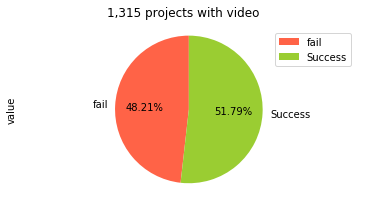

           group  value
fail        fail    634
Success  Success    681
Sum : 1315


In [6]:
group = ['fail','Success']
value = df.groupby(['Success'])['Success'].count().values
pie_df = pd.DataFrame({'group':group,'value':value}, index=['fail','Success'])
total_value = pie_df['value'].sum()
fig = pie_df.plot(kind='pie',y='value',subplots=True, figsize=(6, 3),colors = ['tomato','yellowgreen'],\
                title= '1,315 projects with video', autopct='%.2f%%', startangle=90,shadow=False,\
                fontsize=10)[0]
fig_pie = fig.get_figure()
plt.axis('equal')
plt.show()

fig_pie.savefig('Fig1.pdf')
print(pie_df)
print('Sum : {0}'.format(pie_df['value'].sum()))

### Histogram

In [7]:
from scipy import stats
import numpy as np
# 최적의 bin개수 구하기
# stats.iqr(df['Project_goal'], rng=(25, 75), scale="raw", nan_policy="omit")

In [8]:
def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
    return(result)

In [9]:
# Calculate bins
freedman_diaconis(data=df['Project_goal'], returnas="bins")

14086

### 전체 Data의 Project별 Category 숫자

/Users/yonggeol/miniconda3/envs/py/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 14 x 6 in image.
  from_inches(height, units), units))
/Users/yonggeol/miniconda3/envs/py/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: Project categories histogram.pdf
  warn('Filename: {}'.format(filename))


<Figure size 72x576 with 0 Axes>

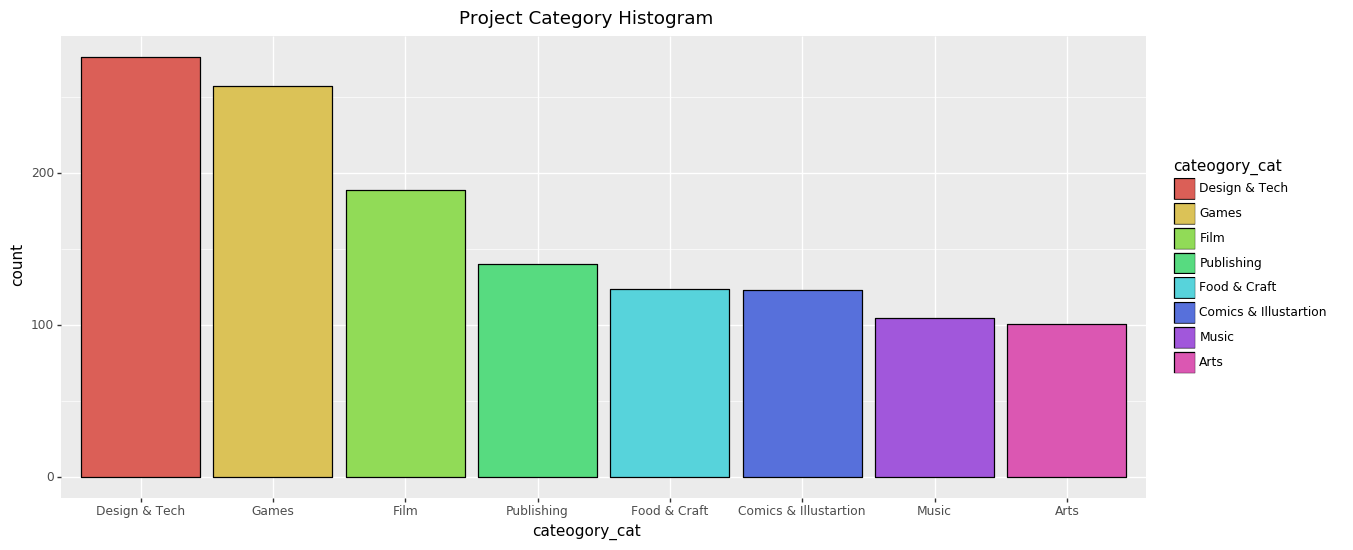

<ggplot: (-9223372036572981034)>

In [10]:
# Determine order and create a categorical type
cateogory_list = df['super_category'].value_counts().index.tolist()
cateogory_cat = CategoricalDtype(categories=cateogory_list, ordered=True)
df['cateogory_cat'] = df['super_category'].astype(str).astype(cateogory_cat)

plt.rcParams['figure.figsize'] = [1, 8]
fig = plt.figure()

# graph 객체 생성
cate_hist = ggplot(df, aes('cateogory_cat',fill='cateogory_cat')) \
    + geom_bar(colour="black") \
    + ggtitle('Project Category Histogram') \
    + theme(figure_size=(14, 6))
cate_hist.save('Project categories histogram.pdf')
cate_hist

In [11]:
# Total
print(pd.DataFrame(df.groupby(['cateogory_cat'])['cateogory_cat'].count())['cateogory_cat'].sum())
pd.DataFrame(df.groupby(['cateogory_cat'])['cateogory_cat'].count())

1315


,cateogory_cat
cateogory_cat,
Design & Tech,276
Games,257
Film,189
Publishing,140
Food & Craft,124
Comics & Illustartion,123
Music,105
Arts,101


### 성공/실패 Project별 Category 숫자

In [12]:
df

,Project_Id,Project_launched_at,Project_deadline,Project_goal,Project_category,Date,Days_to_go,Pledged,Options_number,Title_count,...,Success,backer1,backer2,backer3,ratio1,ratio2,ratio3,Top_category,super_category,cateogory_cat
0,1000414645,1560292936,1562884936,10000.0,Science Fiction,1.562814e+09,19,20139.0,12.0,35.0,...,1,13,17,25,37.730000,39.180000,44.940000,Film & Video,Film,Film
1,1002877193,1559689942,1562281942,3000.0,Video Games,1.562213e+09,19,3217.0,9.0,13.0,...,1,127,149,153,48.733333,56.233333,58.400000,Games,Games,Games
2,1002950518,1559343638,1561935638,500.0,Comics,1.561874e+09,17,1306.0,11.0,47.0,...,1,15,19,22,77.600000,89.800000,105.800000,Comics,Comics & Illustartion,Comics & Illustartion
3,1006560474,1559058077,1561650077,100.0,Product Design,1.561596e+09,15,461.0,3.0,48.0,...,1,12,17,18,124.000000,173.000000,185.000000,Design,Design & Tech,Design & Tech
4,1006860742,1558561181,1561500000,12000.0,Small Batch,1.561423e+09,21,202.0,16.0,54.0,...,0,2,2,2,0.841667,0.841667,0.841667,Food,Food & Craft,Food & Craft
5,1009113591,1559391306,1561205706,250.0,Tabletop Games,1.561175e+09,8,5582.0,5.0,33.0,...,1,33,43,48,499.600000,644.000000,714.800000,Games,Games,Games
6,1009383623,1560908685,1562691600,2500.0,Drama,1.562641e+09,14,3.0,5.0,26.0,...,0,2,2,2,0.080000,0.080000,0.080000,Film & Video,Film,Film
7,1009609091,1560175216,1562767216,2000.0,Product Design,1.562726e+09,11,1624.0,4.0,45.0,...,0,12,13,15,29.950000,32.300000,37.150000,Design,Design & Tech,Design & Tech
8,1012175769,1560441423,1562990340,2000.0,Comic Books,1.562899e+09,25,2467.0,6.0,60.0,...,1,5,6,6,3.050000,4.300000,4.300000,Comics,Comics & Illustartion,Comics & Illustartion
9,1012629901,1559574000,1560265200,45000000.0,Video Games,1.560233e+09,9,810454.0,18.0,59.0,...,0,"2,156","3,696","4,563",0.592338,0.954411,1.158909,Games,Games,Games


In [13]:
df['Success'] = df['Success'].apply(lambda x : 'Success' if x == 1 else 'Fail')

In [14]:
# success_dict = {1:'Success',0:"Fail"}
# df['Success'] = df['Success'].map(success_dict)

/Users/yonggeol/miniconda3/envs/py/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 14 x 6 in image.
  from_inches(height, units), units))
/Users/yonggeol/miniconda3/envs/py/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: Project categories histogram by success.pdf
  warn('Filename: {}'.format(filename))


<Figure size 72x576 with 0 Axes>

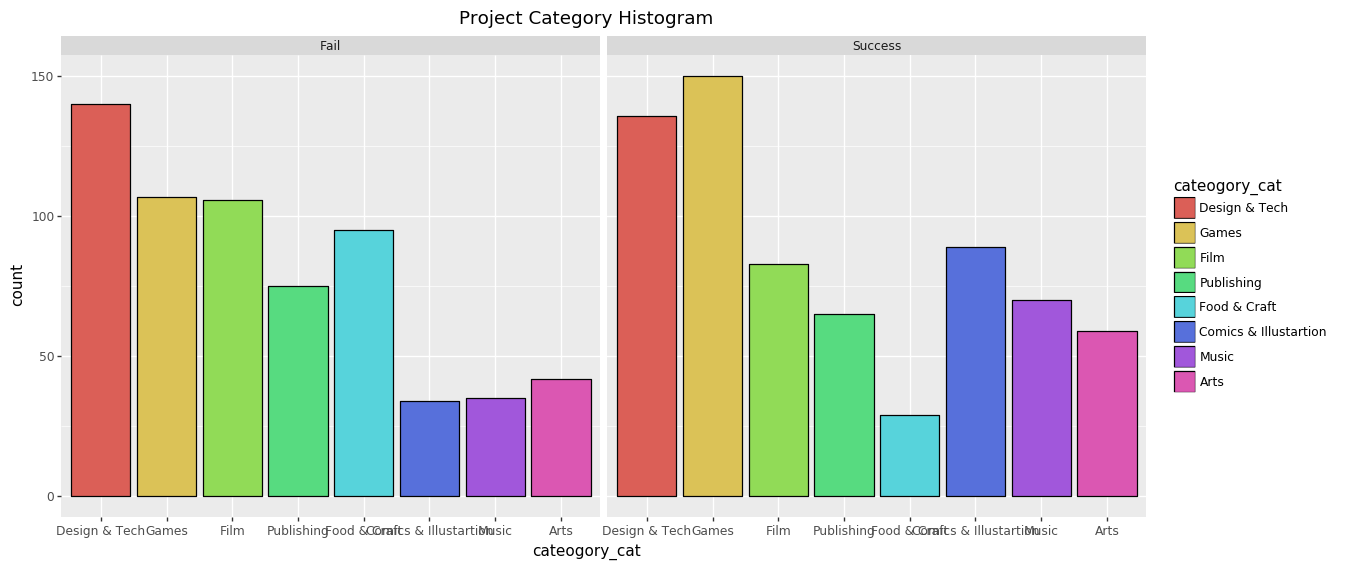

<ggplot: (-9223372036573831599)>

In [15]:
plt.rcParams['figure.figsize'] = [1, 8]
fig = plt.figure()


# graph 객체 생성
com_plot = ggplot(df, aes('cateogory_cat',fill='cateogory_cat')) \
    + geom_bar(colour="black") \
    + ggtitle('Project Category Histogram') \
    + theme(figure_size=(14, 6))\
    + facet_wrap('~Success')
com_plot.save('Project categories histogram by success.pdf')
com_plot

In [16]:
Success_df = df[df['Success'] == 'Success']
Fail_df = df[df['Success'] == 'Fail']

In [17]:
# success
print('Success')
Success_df.groupby(['cateogory_cat'])['cateogory_cat'].count()
print(pd.DataFrame(Success_df.groupby(['cateogory_cat'])['cateogory_cat'].count())['cateogory_cat'].sum())
pd.DataFrame(Success_df.groupby(['cateogory_cat'])['cateogory_cat'].count())
#print(pd.DataFrame(Success_df.groupby(['cateogory_cat'])['cateogory_cat'].count()).sum())

Success
681


,cateogory_cat
cateogory_cat,
Design & Tech,136
Games,150
Film,83
Publishing,65
Food & Craft,29
Comics & Illustartion,89
Music,70
Arts,59


In [18]:
# fails
print('Fail')
Fail_df.groupby(['cateogory_cat'])['cateogory_cat'].count()
print(pd.DataFrame(Fail_df.groupby(['cateogory_cat'])['cateogory_cat'].count())['cateogory_cat'].sum())
pd.DataFrame(Fail_df.groupby(['cateogory_cat'])['cateogory_cat'].count())
#print(pd.DataFrame(Fail_df.groupby(['cateogory_cat'])['cateogory_cat'].count()).sum())

Fail
634


,cateogory_cat
cateogory_cat,
Design & Tech,140
Games,107
Film,106
Publishing,75
Food & Craft,95
Comics & Illustartion,34
Music,35
Arts,42


### Extracting random porject Id 

In [19]:
# In the case of success
Success_Id = Success_df['Project_Id'].values
np.random.choice(Success_Id,50)

array([1489361926,  147169215,   11243100, 1213783544, 1581146582,
       1513077935, 1032176728, 2052246802,   72527308, 1380001178,
        406223570, 2050859840, 1012175769, 1025123568, 2049000101,
       1084357918,  400430840,  138549713,  717187088, 1557406864,
       1308383780, 1955755843, 1282800760,  978592772, 2136746413,
       1430474194, 1944426043, 1770412175,  420452773, 1227911218,
        182769150, 1463810948, 1300393869, 1807948062, 1212882782,
       1469195434,  537519744,  504772620,  451289551, 2136746413,
       1908558150,  479150314, 2112987587,    6843704, 1638676452,
        871180973, 1872215678, 1503617616,  221360354, 1623330262])

In [20]:
# In the case of fail
Fail_df
Fail_Id = Fail_df['Project_Id'].values
np.random.choice(Fail_Id,50)

array([1783949752,  566209227, 1614278862, 1334009474,  505675728,
        981938053,  892268762,  574736647,  929129977, 1884063012,
       2063081220,   75394555, 1144116126,  315565390, 1231026666,
        444933911,   25582256,   99507878, 1596530564, 1719559995,
        201094374,  839944311, 1874252162,   54802184, 1206032925,
        925076234, 1753734345, 1177044994, 1614278862, 1522183628,
        342390753, 1786636139, 2016349390, 1173546715, 1779087933,
       1591645300,  260406146,  979164415, 1823327780, 1138432882,
        444032011, 1170921814,  150569889, 1177044994,  751507946,
         29543668, 1015061740,   75394555, 1658489687, 1452525866])